In [111]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import datetime
import os, sys

In [112]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [113]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [115]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, num_classes=1):
        
        super(Discriminator, self).__init__()

        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )

        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [116]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_size, 4*4*512),
            nn.ReLU(),
        )

        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_)
        return y_

In [117]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [118]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

In [119]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [120]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [121]:
numberOfEpochs = 21
step = 0
n_critic = 1 # k steps about D
n_noise = 100

In [122]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # fake

In [123]:
for epoch in range(numberOfEpochs):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, numberOfEpochs, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            G.train()
        step += 1

Epoch: 0/21, Step: 0, D Loss: 1.4005764722824097, G Loss: 0.6122380495071411
Epoch: 0/21, Step: 500, D Loss: 0.699822187423706, G Loss: 1.0505948066711426
Epoch: 1/21, Step: 1000, D Loss: 0.887744665145874, G Loss: 1.9006403684616089
Epoch: 1/21, Step: 1500, D Loss: 0.6414382457733154, G Loss: 1.64603590965271
Epoch: 2/21, Step: 2000, D Loss: 0.6310254335403442, G Loss: 0.9683728814125061
Epoch: 2/21, Step: 2500, D Loss: 0.4077147841453552, G Loss: 1.986769676208496
Epoch: 3/21, Step: 3000, D Loss: 0.6273844838142395, G Loss: 1.9089195728302002
Epoch: 3/21, Step: 3500, D Loss: 0.58885258436203, G Loss: 2.7194533348083496
Epoch: 4/21, Step: 4000, D Loss: 0.4431149363517761, G Loss: 2.4377074241638184
Epoch: 4/21, Step: 4500, D Loss: 0.39726412296295166, G Loss: 2.838071823120117
Epoch: 5/21, Step: 5000, D Loss: 0.7500532865524292, G Loss: 2.6509034633636475
Epoch: 5/21, Step: 5500, D Loss: 0.5884911417961121, G Loss: 1.4566423892974854
Epoch: 6/21, Step: 6000, D Loss: 0.5605299472808838

In [134]:
G.eval()

Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU()
  )
  (conv): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [131]:
def print_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

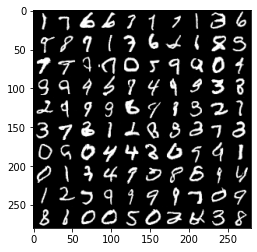

In [132]:
imshow(print_image(G, n_noise), cmap='gray')